'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


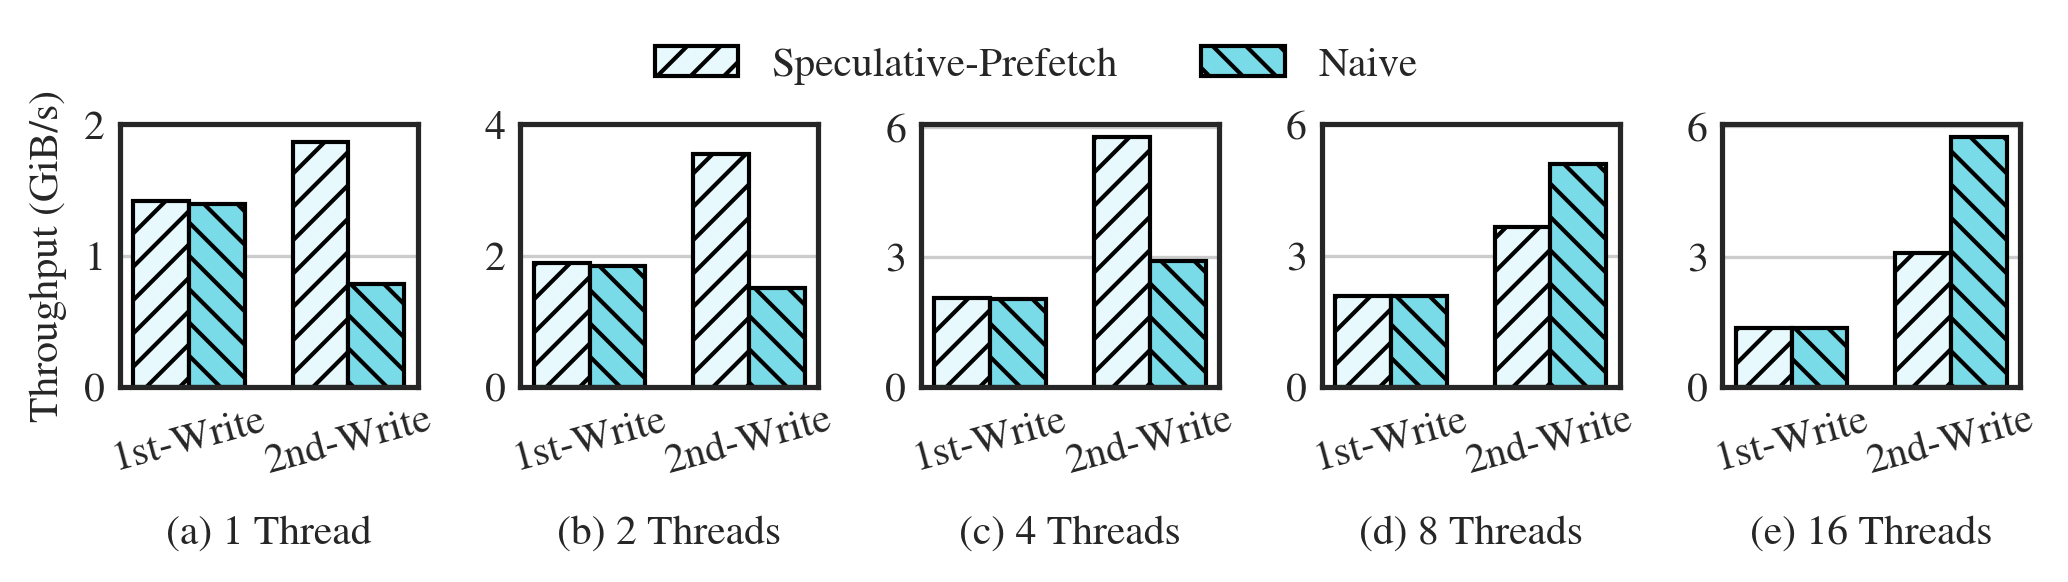

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, engine='python')


# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(4.5)))
bar_width = 0.35
subfig_titles = ["(a) 1 Thread", "(b) 2 Threads", "(c) 4 Threads", "(d) 8 Threads", "(e) 16 Threads"]
patterns = ['///', '\\\\\\', '', 'XXX', "OOO"]
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#E8F9FD", "#79DAE8", "#0AA1DD", "#2155CD", "#0A0A0A"]
num_jobs = [1, 2, 4, 8, 16]

for i in range(5):
    subfig = plt.subplot(1, 5, i + 1)
    xs = [1, 2]
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    patterns = ['///', '\\\\\\', 'XXX', "OOO"]
    colors = ["#E8F9FD", "#79DAE8", "#2155CD", "#0A0A0A"]
    tot = len(fss) * bar_width
    for idx, fs in enumerate(fss):
        points = []
        for x in xs: 
            pivot = x
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        bw_1st = df[(df['file_system'] == fs) & (df['num_job'] == num_jobs[i])]['first_bandwidth(MiB/s)'] / 1024
        bw_2nd = df[(df['file_system'] == fs) & (df['num_job'] == num_jobs[i])]['second_bandwidth(MiB/s)'] / 1024
        bw = bw_1st.append(bw_2nd)
        plt.bar(points, bw, width=bar_width, hatch=patterns[idx], edgecolor='black', color=colors[idx])


    plt.xticks(xs, labels=["1st-Write", "2nd-Write"], rotation=15)
    if i == 0:
        plt.ylabel('Throughput (GiB/s)')
        plt.yticks([0, 2, 1])
    elif i == 1:
        plt.yticks([0, 4, 2])
    elif i == 2:
        plt.yticks([0, 6, 3])
    elif i >= 3:
        plt.yticks([0, 6, 3])
    
    # Draw title
    # subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
    plt.xlabel(subfig_titles[i], labelpad = 8)
            
fig.legend(fss, loc='center', ncol=len(fss), bbox_to_anchor=(0.5, 1))
            
plt.tight_layout()
plt.savefig("./FIG-Prefetch-All.pdf", bbox_inches='tight', pad_inches=0)

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


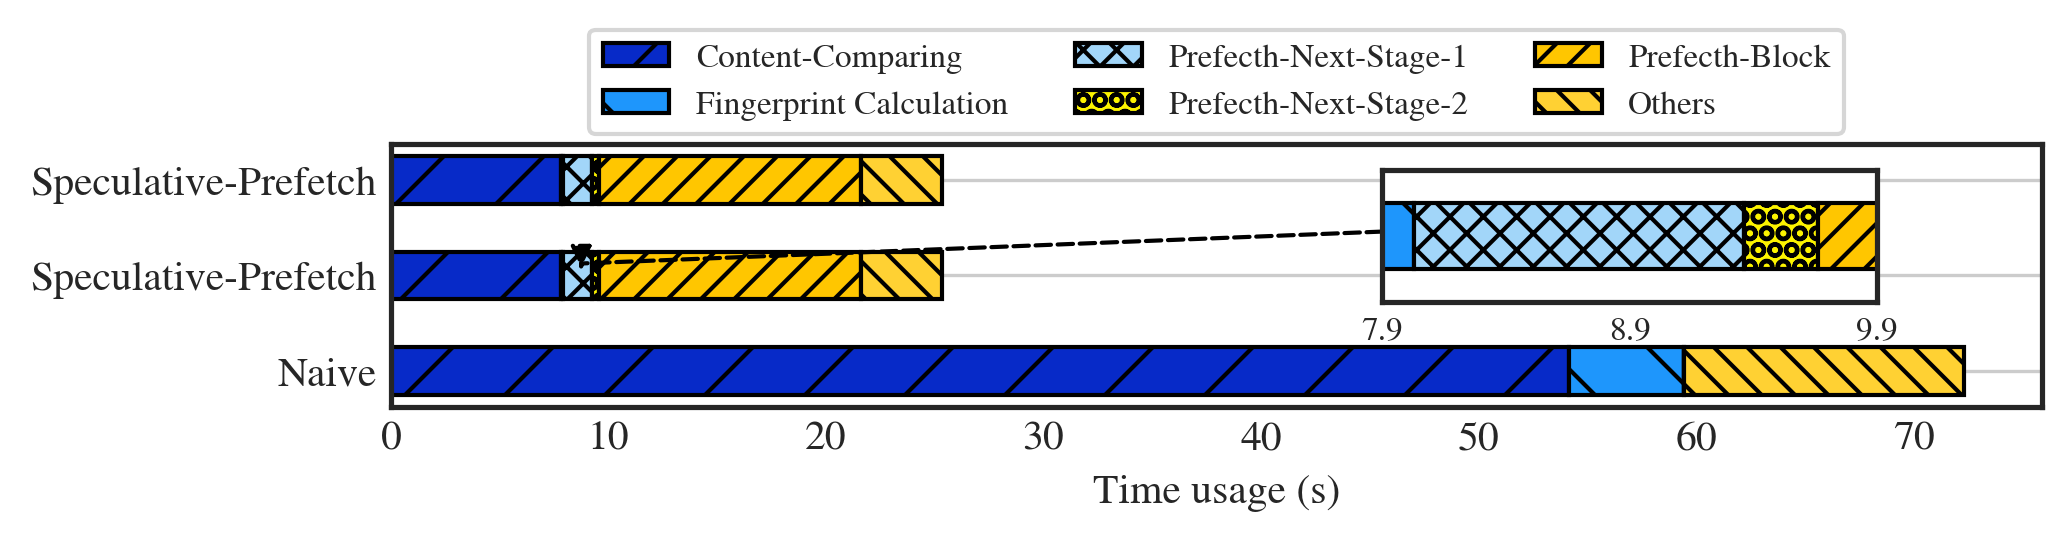

In [127]:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))
subfig = plt.subplot(1, 1, 1)
figins = subfig.inset_axes((0.6, 0.4, 0.3, 0.5))
# figins.xaxis.set_visible(False)
figins.yaxis.set_visible(False)
figins.set_xlim([0, 2])
bar_width = 0.5
inner_width = 0.1

num_job = 1
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']

# Pseudo
# fss.loc[2] = "Speculative-Prefetch"
fss = ["Naive", "Speculative-Prefetch", "Speculative-Prefetch"]

times = ["second_cmp_lat(ns)", "second_fp_lat(ns)", "second_prefetch_next_stage1_lat(ns)", "second_prefetch_next_stage2_lat(ns)", "second_prefetch_cmp_lat(ns)", "second_others_lat(ns)"]
# Reference: https://coolors.co/palettes/popular/6%20colors
colors = ["#2e59b7", "#1e96fc", "#a2d6f9", "#fcf300", "#ffc600", "#ffd133"]
patterns = ['/', '\\', 'XXX', "OOO", "///", "\\\\\\"]

x = list(range(1, len(fss) + 1))
for fs_id, fs in enumerate(fss):
    left = 0
    pivot = x[fs_id]
    inner_left = 0
    inner_left_range = []
    start = False
    for idx, time in enumerate(times):
        width = df[(df['file_system'] == fs) & (df['num_job'] == num_job)][time].iloc[0] / 1000000000 # s
        plt.barh(y=pivot, width=width, color=colors[idx], edgecolor='black', left=left, height=bar_width, hatch=patterns[idx])
        left = left + width
        if width < 2 and fs_id == 1:
            start = True
        if start:
            if width < 2:
                figins.barh(y=0, width=width, color=colors[idx], edgecolor='black', left=inner_left, height=inner_width, hatch=patterns[idx])
                inner_left_range.append(left)
            else:
                figins.barh(y=0, width=width, color=colors[idx], edgecolor='black', left=inner_left, height=inner_width, hatch=patterns[idx])
            inner_left = inner_left + width
    
    if len(inner_left_range):
        avg = (inner_left_range[0] + inner_left_range[-1]) / 2
        # Note: Strange ... We must set "arc,angleA=-90,armA=0,angleB=90,rad=10,armB=50" to "arc,angleA=-90,armA=0,angleB=90,rad=3,armB=12" to get savefig normal (Note that the pic in jupyter notebook is abnormal in this configuration).
        plt.annotate("", xy=(avg, pivot), xytext=(50, 2.5), arrowprops=dict(arrowstyle="-|>", color="black", connectionstyle="arc,angleA=-90,armA=0,angleB=90,rad=3,armB=12", linestyle="--"))
        figins.set_xticks([0, 1, 2])
        figins.set_yticks([-0.1, 0, 0.1])
        figins.set_xticklabels([round(inner_left_range[0], 1), round(inner_left_range[0] + 1, 1), round(inner_left_range[0] + 2, 1)], fontsize=8)

plt.yticks(x, labels=fss)
plt.xlabel("Time usage (s)")
legends = ["Content-Comparing", "Fingerprint Calculation","Prefecth-Next-Stage-1", "Prefecth-Next-Stage-2", "Prefecth-Block", "Others"]
plt.legend(legends, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.5), frameon=True, fontsize=8)
plt.tight_layout()
plt.savefig("./FIG-{0}-Thread(s)-Breakdown.pdf".format(num_job), bbox_inches='tight', pad_inches=0)


# Obsoleted Codes

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


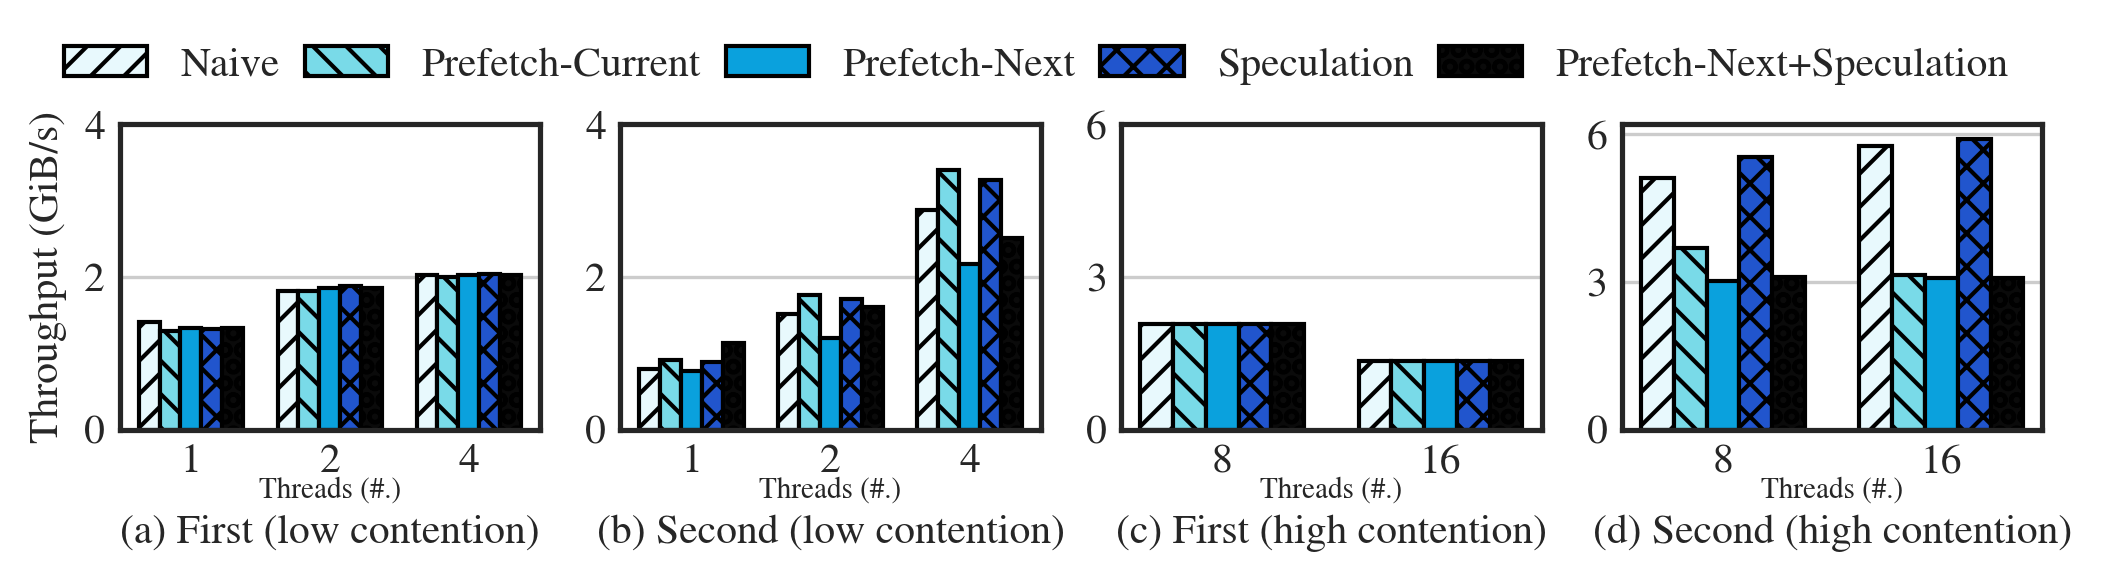

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
with open("./avg-test-result-in-paper", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, engine='python')

sort_dict = {
    "Naive" : 0, 
    "Prefetch-Current" : 1,  
    "Prefetch-Next" : 2,  
    "Speculation" : 3, 
    "Prefetch-Next+Speculation" : 4
}

sort_df = pd.DataFrame(df['file_system'].map(sort_dict))
sort_df["num_job"] = df['num_job']
df = df.iloc[sort_df.sort_values(by = ["file_system", "num_job"]).index]

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(4.5)))
bar_width = 0.15
subfig_titles = ["(a) First (low contention)", "(b) Second (low contention)", "(c) First (high contention)", "(d) Second (high contention)"]
patterns = ['///', '\\\\\\', '', 'XXX', "OOO"]
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#E8F9FD", "#79DAE8", "#0AA1DD", "#2155CD", "#0A0A0A"]
xs = [[1, 2, 3], [1, 2, 3], [4, 5], [4, 5]]

for i in range(4):
    subfig = plt.subplot(1, 4, i + 1)
    x = xs[i]
    x_label = [1, 2, 4] if len(x) == 3 else [8, 16]
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    tot = len(fss) * bar_width
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        plt.bar(points, df[(df['file_system'] == fs) & (df['num_job'] <= max(x_label)) & (df['num_job'] >= min(x_label))]['first_bandwidth(MiB/s)' if i % 2 == 0 else 'second_bandwidth(MiB/s)'] / 1024, width=bar_width, hatch=patterns[idx], edgecolor='black', color=colors[idx])
        
        if i < 2:
            plt.yticks([0, 2, 4])
        else:
            plt.yticks([0, 3, 6])

        plt.xticks(x, labels=x_label)
        if i == 0:
            plt.ylabel('Throughput (GiB/s)')

    # Draw title
    subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
    plt.xlabel(subfig_titles[i], labelpad = 8)
            
fig.legend(fss, loc='center', ncol=5, columnspacing = 0.6, bbox_to_anchor=(0.5, 1),)

plt.tight_layout()
plt.savefig("./FIG-Prefetch-All.pdf", bbox_inches='tight', pad_inches=0)


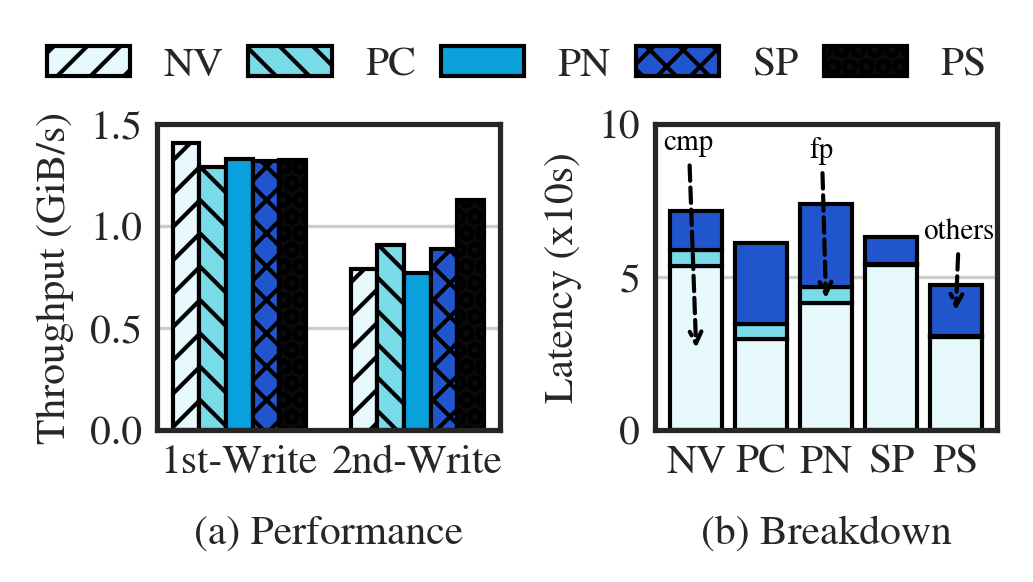

In [6]:
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4.5)))
bar_width = 0.15
subfig_titles = ["(a) Performance", "(b) Breakdown"]
patterns = ['///', '\\\\\\', '', 'XXX', "OOO"]
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#E8F9FD", "#79DAE8", "#0AA1DD", "#2155CD", "#0A0A0A"]

subfig = plt.subplot(1, 2, 1)
xs = [1, 2]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
tot = len(fss) * bar_width
for idx, fs in enumerate(fss):
    points = []
    for x in xs: 
        pivot = x
        point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
        points.append(point)
    bw_1st = df[(df['file_system'] == fs) & (df['num_job'] == 1)]['first_bandwidth(MiB/s)'] / 1024
    bw_2nd = df[(df['file_system'] == fs) & (df['num_job'] == 1)]['second_bandwidth(MiB/s)'] / 1024
    bw = bw_1st.append(bw_2nd)
    plt.bar(points, bw, width=bar_width, hatch=patterns[idx], edgecolor='black', color=colors[idx])


plt.xticks(xs, labels=["1st-Write", "2nd-Write"])
plt.ylabel('Throughput (GiB/s)')
plt.yticks(np.arange(0, 2, 0.5))
# Draw title
# subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
plt.xlabel(subfig_titles[0], labelpad = 8)
            
fig.legend(fss.map({
    "Naive" : "NV",
    "Prefetch-Current" : "PC",
    "Prefetch-Next" : "PN",
    "Speculation" : "SP",
    "Prefetch-Next+Speculation" : "PS"
}), loc='center', ncol=5, columnspacing = 0.6, bbox_to_anchor=(0.5, 1),)

subfig = plt.subplot(1, 2, 2)
xs = list(range(0, len(fss)))
num_job = 1
# second_cmp_lat(ns) second_fp_lat(ns) second_others_lat(ns) second_lat(ns)
for idx, fs in enumerate(fss):
    NS = 1000 * 1000 * 1000 * 10
    cmp_lat = df[(df['file_system'] == fs) & (df['num_job'] == num_job)]['second_cmp_lat(ns)'].iloc[0] / NS
    fp_lat = df[(df['file_system'] == fs) & (df['num_job'] == num_job)]['second_fp_lat(ns)'].iloc[0] / NS
    others_lat = df[(df['file_system'] == fs) & (df['num_job'] == num_job)]['second_others_lat(ns)'].iloc[0] / NS
    
    plt.bar(idx, cmp_lat, color=colors[0], edgecolor='black')
    plt.bar(idx, fp_lat, bottom=cmp_lat, color=colors[1], edgecolor='black')
    plt.bar(idx, others_lat, bottom=cmp_lat + fp_lat, color=colors[3], edgecolor='black')
    
    if idx == 0:
        plt.annotate("cmp", xy=(idx, cmp_lat / 2), xytext=(idx - 0.5, cmp_lat + fp_lat + others_lat + 2), fontsize=7, xycoords='data', color='black', arrowprops = dict(facecolor="red", linestyle="--",shrinkA=0, shrinkB=0, arrowstyle="->"))
    if idx == 2:
        plt.annotate("fp", xy=(idx, cmp_lat + fp_lat / 2 - 0.1), xytext=(idx - 0.25, cmp_lat + fp_lat + others_lat + 1.5), fontsize=7, xycoords='data', color='black', arrowprops = dict(facecolor="red", linestyle="--",shrinkA=0, shrinkB=0, arrowstyle="->"))
    if idx == 4:
        plt.annotate("others", xy=(idx, cmp_lat + fp_lat + others_lat / 2), xytext=(idx - 0.5, cmp_lat + fp_lat + others_lat + 1.5), fontsize=7, xycoords='data', color='black', arrowprops = dict(facecolor="red", shrinkA = 0, shrinkB = 0, linestyle="--",arrowstyle="->"))
  
# plt.legend(["cmp", "fp", "others"], loc='center', ncol = 3)

plt.xticks(xs, labels=["NV", "PC", "PN", "SP", "PS"])
plt.yticks([0, 5, 10])
plt.ylabel('Latency (x10s)')
# Draw title
# subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
plt.xlabel(subfig_titles[1], labelpad = 8)
            
plt.tight_layout()
# plt.savefig("./FIG-Prefetch-Single-Thread.pdf", bbox_inches='tight', pad_inches=0)

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


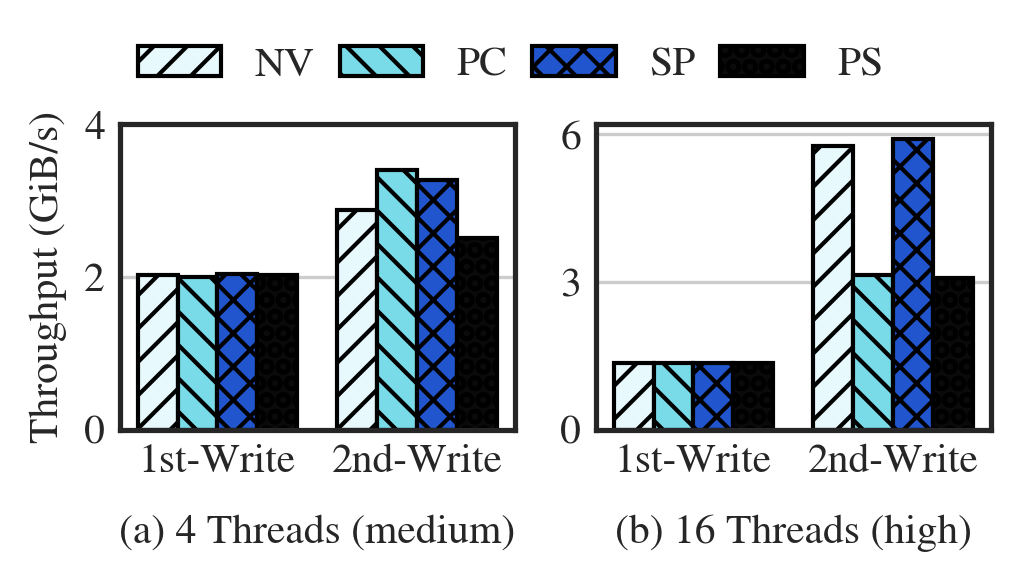

In [4]:
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4.5)))
bar_width = 0.2
subfig_titles = ["(a) 4 Threads (medium)", "(b) 16 Threads (high)"]
patterns = ['///', '\\\\\\', '', 'XXX', "OOO"]
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#E8F9FD", "#79DAE8", "#0AA1DD", "#2155CD", "#0A0A0A"]
num_jobs = [4, 16]

for i in range(2):
    subfig = plt.subplot(1, 2, i + 1)
    xs = [1, 2]
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    # print(fss)
    fss = fss.drop(2)
    patterns = ['///', '\\\\\\', 'XXX', "OOO"]
    colors = ["#E8F9FD", "#79DAE8", "#2155CD", "#0A0A0A"]
    tot = len(fss) * bar_width
    for idx, fs in enumerate(fss):
        points = []
        for x in xs: 
            pivot = x
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        bw_1st = df[(df['file_system'] == fs) & (df['num_job'] == num_jobs[i])]['first_bandwidth(MiB/s)'] / 1024
        bw_2nd = df[(df['file_system'] == fs) & (df['num_job'] == num_jobs[i])]['second_bandwidth(MiB/s)'] / 1024
        bw = bw_1st.append(bw_2nd)
        plt.bar(points, bw, width=bar_width, hatch=patterns[idx], edgecolor='black', color=colors[idx])


    plt.xticks(xs, labels=["1st-Write", "2nd-Write"])
    if i == 0:
        plt.ylabel('Throughput (GiB/s)')
        plt.yticks([0, 2, 4])
    else:
        plt.yticks([0, 3, 6])
    # Draw title
    # subfig.text(0.5, -0.2, "Threads (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)
    plt.xlabel(subfig_titles[i], labelpad = 8)
            
fig.legend(fss.map({
    "Naive" : "NV",
    "Prefetch-Current" : "PC",
    "Speculation" : "SP",
    "Prefetch-Next+Speculation" : "PS"
}), loc='center', ncol=5, columnspacing = 0.6, bbox_to_anchor=(0.5, 1),)
            
plt.tight_layout()
plt.savefig("./FIG-Prefetch-Transition.pdf", bbox_inches='tight', pad_inches=0)